- Label Smoothing
  - Definition
    - One of techniques to prevent overfitting issues, especially in classification models
    - Modifying target labels in the training dataset by adding a small amount of uniform noise to ground truths which are usually one-hot- encoded (between '0' and '1')

### Preparation

In [1]:
# Import modules
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision.transforms import ToTensor

### Define a Custom Loss Function (Cross Entropy Loss with Label Smoothing)

In [2]:
# Define a class for Custom Loss Function
class LabelSmoothingLoss (nn.Module):
    # Initialize the class
    def __init__(self, num_classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.num_classes = num_classes     # Number of classes for Classification
        self.smoothing = smoothing         # 'Smoothing=0.0': Smoothing not applied
        self.confidence = 1.0 - smoothing  # Correlation value of Smoothing (Confidence score for correct answers)

        
    # Forward
    def forward(self, pred, target):  # 'pred': Predictions, 'target': Correct answers
        # Generate One-Hot Encoding Tensor
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        
        #  Apply Label Smoothing to One-Hot encoded tensor -> Confidence score
        smooth_label = one_hot * self.confidence + (1 - one_hot) * self.smoothing / (self.num_classes - 1)
        
        # Calculate loss between predictions and labels with Smoothing Labels by using Cross Entropy Loss
        #  -> (a probability of 'log_softmax') X (Label Smoothing)
        loss = torch.sum(-smooth_label * torch.log_softmax(pred, dim=1),   # '-smooth_label': 
                         dim=1)  
        
        # Return with Mean of Loss
        return torch.mean(loss)

### Define a Model

In [13]:
# Define a model
class MyModel(nn.Module):
    # Initialize the model
    def __init__(self):
        super(MyModel, self).__init__()
        
        ##### Feature Extraction
        # Layer set 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU(inplace = True)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        # Layer set 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
        self.relu2 = nn.ReLU(inplace = True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        ##### 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*5*5, 128)
        self.relu3 = nn.ReLU(inplace = True)
        self.fc2 = nn.Linear(128, 10)
        
        
    # Forward
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

### Load Dataset and DataLoader

In [14]:
# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root = './data/0706-FashionMNIST',
                                                  train = True,
                                                  transform = ToTensor(),
                                                  download = True)

# Set DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = 64,
                                               shuffle = True)

### Define a Model

In [16]:
# Define a model
model = MyModel()

print(model)


MyModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Set Loss Function and Optimizer

In [17]:
# Set Loss Function
num_classes = 10
smoothing = 0.1
criterion = LabelSmoothingLoss(num_classes, smoothing)

# Set Optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)


### Fit a Model

In [18]:
# Initialize lists of train losses
train_losses_no_smoothing = []
train_losses_with_smoothing = []

In [20]:
# Fit a model
num_epochs = 10
for epoch in range(num_epochs):
    # Initialize default values for train loss
    train_loss_no_smoothing = 0.0
    train_loss_with_smoothing = 0.0
    
    # Fit a model
    for inputs, labels in train_dataloader:
        # Initialize optimizer with '0'
        optimizer.zero_grad()
        
        # Set Train Loss without Smoothing
        outputs_no_smoothing = model(inputs)
        loss_no_smoothing = criterion(outputs_no_smoothing, labels)
        loss_no_smoothing.backward()
        optimizer.step()
        train_loss_no_smoothing += loss_no_smoothing.item()
        
        # Set Train Loss with Smoothing
        outputs_with_smoothing = model(inputs)
        loss_with_smoothing = criterion(outputs_with_smoothing, labels)
        loss_with_smoothing.backward()
        optimizer.step()
        train_loss_with_smoothing += loss_with_smoothing.item()
        
    # Record loss by each epoch
    train_losses_no_smoothing.append(train_loss_no_smoothing / len(train_dataloader))
    train_losses_with_smoothing.append(train_loss_with_smoothing / len(train_dataloader))

In [23]:
print(train_losses_no_smoothing)
print(train_losses_with_smoothing)

[0.9861963740798202, 0.8139742395516906, 0.77837562313212, 0.754886957437499, 0.7383785308805356, 0.7259798941454654, 0.7126440023943814, 0.7018055704229677, 0.691883472173707, 0.6839737181724516]
[0.981137675453605, 0.8100807835806662, 0.7745480173305154, 0.751055829115768, 0.7344796428802425, 0.7219040520282697, 0.7085616211138809, 0.6975289120602963, 0.6876977542315973, 0.679568292108426]


### Visualization

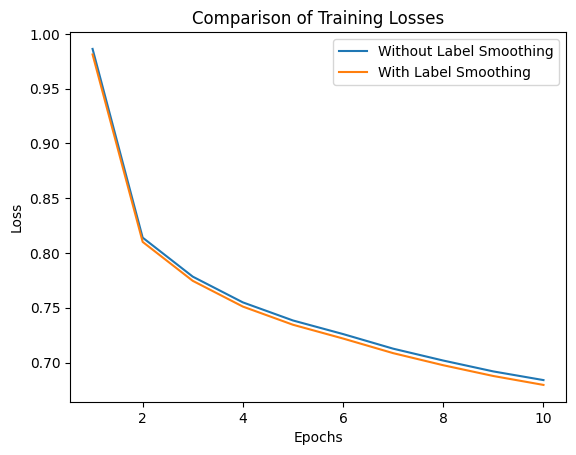

In [21]:
# Set epochs
epochs = range(1, num_epochs + 1)

# Visualization 
plt.plot(epochs, train_losses_no_smoothing, label = 'Without Label Smoothing')
plt.plot(epochs, train_losses_with_smoothing, label = 'With Label Smoothing')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Training Losses')

plt.legend()
plt.show()